In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../../data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
         0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
         0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
         0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80,\
         0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
i_beta_32_08 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 50    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 0.8
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_32_08[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 27.559611558914185 
    loop_MC 1 - time has passed: 89.285879611969 
    loop_MC 2 - time has passed: 138.71475648880005 
    loop_MC 3 - time has passed: 210.25804615020752 
    loop_MC 4 - time has passed: 263.2359662055969 
    loop_MC 5 - time has passed: 312.8336057662964 
    loop_MC 6 - time has passed: 378.62531065940857 
    loop_MC 7 - time has passed: 432.6064295768738 
    loop_MC 8 - time has passed: 500.4652190208435 
    loop_MC 9 - time has passed: 551.6979601383209 
    loop_MC 10 - time has passed: 607.9465353488922 
    loop_MC 11 - time has passed: 656.6495399475098 
    loop_MC 12 - time has passed: 709.7584438323975 
    loop_MC 13 - time has passed: 768.5685408115387 
    loop_MC 14 - time has passed: 811.04807472229 
    loop_MC 15 - time has passed: 867.580971956253 
    loop_MC 16 - time has passed: 914.9309365749359 
    loop_MC 17 - time has passed: 964.5757429599762 
    loop_MC 18 - time has passed: 1005.2865912914276 
   

    loop_MC 2 - time has passed: 186.41907668113708 
    loop_MC 3 - time has passed: 237.29018330574036 
    loop_MC 4 - time has passed: 300.21972250938416 
    loop_MC 5 - time has passed: 340.93240666389465 
    loop_MC 6 - time has passed: 397.0407633781433 
    loop_MC 7 - time has passed: 458.0189619064331 
    loop_MC 8 - time has passed: 514.9069440364838 
    loop_MC 9 - time has passed: 578.5150244235992 
    loop_MC 10 - time has passed: 643.5126047134399 
    loop_MC 11 - time has passed: 697.8372871875763 
    loop_MC 12 - time has passed: 749.2571589946747 
    loop_MC 13 - time has passed: 812.4345874786377 
    loop_MC 14 - time has passed: 879.034562587738 
    loop_MC 15 - time has passed: 936.8403644561768 
    loop_MC 16 - time has passed: 1004.7333250045776 
    loop_MC 17 - time has passed: 1056.4027564525604 
    loop_MC 18 - time has passed: 1122.60311627388 
    loop_MC 19 - time has passed: 1178.7794916629791 
    loop_MC 20 - time has passed: 1226.3195750713

    loop_MC 4 - time has passed: 288.5397083759308 
    loop_MC 5 - time has passed: 337.52838706970215 
    loop_MC 6 - time has passed: 397.8954074382782 
    loop_MC 7 - time has passed: 456.4963262081146 
    loop_MC 8 - time has passed: 512.7206890583038 
    loop_MC 9 - time has passed: 573.2136096954346 
    loop_MC 10 - time has passed: 610.3293914794922 
    loop_MC 11 - time has passed: 674.5880863666534 
    loop_MC 12 - time has passed: 735.6498715877533 
    loop_MC 13 - time has passed: 793.097089767456 
    loop_MC 14 - time has passed: 853.2104408740997 
    loop_MC 15 - time has passed: 895.2643949985504 
    loop_MC 16 - time has passed: 960.6957139968872 
    loop_MC 17 - time has passed: 1017.6849362850189 
    loop_MC 18 - time has passed: 1082.1000394821167 
    loop_MC 19 - time has passed: 1144.8784425258636 
    loop_MC 20 - time has passed: 1218.81707072258 
    loop_MC 21 - time has passed: 1276.1955914497375 
    loop_MC 22 - time has passed: 1338.3510775566

    loop_MC 6 - time has passed: 409.69205927848816 
    loop_MC 7 - time has passed: 471.88260984420776 
    loop_MC 8 - time has passed: 525.8019161224365 
    loop_MC 9 - time has passed: 583.2057840824127 
    loop_MC 10 - time has passed: 630.292622089386 
    loop_MC 11 - time has passed: 689.6762537956238 
    loop_MC 12 - time has passed: 751.5970687866211 
    loop_MC 13 - time has passed: 815.0397047996521 
    loop_MC 14 - time has passed: 872.0647599697113 
    loop_MC 15 - time has passed: 933.7118418216705 
    loop_MC 16 - time has passed: 989.8294985294342 
    loop_MC 17 - time has passed: 1050.4383358955383 
    loop_MC 18 - time has passed: 1111.704077720642 
    loop_MC 19 - time has passed: 1169.7596323490143 
    loop_MC 20 - time has passed: 1221.605545759201 
    loop_MC 21 - time has passed: 1275.713892698288 
    loop_MC 22 - time has passed: 1328.7320523262024 
    loop_MC 23 - time has passed: 1386.403060913086 
    loop_MC 24 - time has passed: 1444.9263870

    loop_MC 8 - time has passed: 523.4891138076782 
    loop_MC 9 - time has passed: 593.2180867195129 
    loop_MC 10 - time has passed: 662.1542019844055 
    loop_MC 11 - time has passed: 721.7114455699921 
    loop_MC 12 - time has passed: 771.1576993465424 
    loop_MC 13 - time has passed: 827.8908183574677 
    loop_MC 14 - time has passed: 886.856504201889 
    loop_MC 15 - time has passed: 927.2999801635742 
    loop_MC 16 - time has passed: 987.1712727546692 
    loop_MC 17 - time has passed: 1045.439138174057 
    loop_MC 18 - time has passed: 1104.1291711330414 
    loop_MC 19 - time has passed: 1154.9794006347656 
    loop_MC 20 - time has passed: 1213.8626408576965 
    loop_MC 21 - time has passed: 1279.6525013446808 
    loop_MC 22 - time has passed: 1333.0979187488556 
    loop_MC 23 - time has passed: 1383.1697707176208 
    loop_MC 24 - time has passed: 1443.490892648697 
    loop_MC 25 - time has passed: 1502.3702325820923 
    loop_MC 26 - time has passed: 1574.562

    loop_MC 10 - time has passed: 672.2586152553558 
    loop_MC 11 - time has passed: 740.5154509544373 
    loop_MC 12 - time has passed: 788.8217334747314 
    loop_MC 13 - time has passed: 860.1795310974121 
    loop_MC 14 - time has passed: 910.1359233856201 
    loop_MC 15 - time has passed: 971.5952987670898 
    loop_MC 16 - time has passed: 1022.5038888454437 
    loop_MC 17 - time has passed: 1069.316081047058 
    loop_MC 18 - time has passed: 1138.7632174491882 
    loop_MC 19 - time has passed: 1207.020310163498 
    loop_MC 20 - time has passed: 1254.8009278774261 
    loop_MC 21 - time has passed: 1323.351529598236 
    loop_MC 22 - time has passed: 1383.3225479125977 
    loop_MC 23 - time has passed: 1445.534129858017 
    loop_MC 24 - time has passed: 1503.8624739646912 
    loop_MC 25 - time has passed: 1557.6232171058655 
    loop_MC 26 - time has passed: 1625.701080083847 
    loop_MC 27 - time has passed: 1689.4116060733795 
    loop_MC 28 - time has passed: 1759.

    loop_MC 11 - time has passed: 662.5258617401123 
    loop_MC 12 - time has passed: 712.4741396903992 
    loop_MC 13 - time has passed: 777.8101975917816 
    loop_MC 14 - time has passed: 839.2704725265503 
    loop_MC 15 - time has passed: 894.8884072303772 
    loop_MC 16 - time has passed: 963.0807094573975 
    loop_MC 17 - time has passed: 1026.8580067157745 
    loop_MC 18 - time has passed: 1086.3692891597748 
    loop_MC 19 - time has passed: 1148.9979002475739 
    loop_MC 20 - time has passed: 1199.474797964096 
    loop_MC 21 - time has passed: 1242.0922060012817 
    loop_MC 22 - time has passed: 1290.3785145282745 
    loop_MC 23 - time has passed: 1340.1370010375977 
    loop_MC 24 - time has passed: 1396.224158525467 
    loop_MC 25 - time has passed: 1444.7193286418915 
    loop_MC 26 - time has passed: 1499.2281057834625 
    loop_MC 27 - time has passed: 1563.453766822815 
    loop_MC 28 - time has passed: 1625.5344099998474 
    loop_MC 29 - time has passed: 168

    loop_MC 12 - time has passed: 767.4547433853149 
    loop_MC 13 - time has passed: 828.068336725235 
    loop_MC 14 - time has passed: 880.0821313858032 
    loop_MC 15 - time has passed: 940.5803489685059 
    loop_MC 16 - time has passed: 992.5234270095825 
    loop_MC 17 - time has passed: 1050.2110388278961 
    loop_MC 18 - time has passed: 1105.2896780967712 
    loop_MC 19 - time has passed: 1157.7108464241028 
    loop_MC 20 - time has passed: 1221.4067418575287 
    loop_MC 21 - time has passed: 1289.590381860733 
    loop_MC 22 - time has passed: 1346.3389682769775 
    loop_MC 23 - time has passed: 1403.5548458099365 
    loop_MC 24 - time has passed: 1460.4655504226685 
    loop_MC 25 - time has passed: 1520.6380679607391 
    loop_MC 26 - time has passed: 1587.6600744724274 
    loop_MC 27 - time has passed: 1652.589173078537 
    loop_MC 28 - time has passed: 1703.277760028839 
    loop_MC 29 - time has passed: 1754.4160814285278 
    loop_MC 30 - time has passed: 181

    loop_MC 14 - time has passed: 844.8268208503723 
    loop_MC 15 - time has passed: 907.3078210353851 
    loop_MC 16 - time has passed: 957.0386435985565 
    loop_MC 17 - time has passed: 1020.8490676879883 
    loop_MC 18 - time has passed: 1088.9488294124603 
    loop_MC 19 - time has passed: 1135.9529340267181 
    loop_MC 20 - time has passed: 1199.7703108787537 
    loop_MC 21 - time has passed: 1258.000727891922 
    loop_MC 22 - time has passed: 1315.3168830871582 
    loop_MC 23 - time has passed: 1378.154304742813 
    loop_MC 24 - time has passed: 1442.1164860725403 
    loop_MC 25 - time has passed: 1494.9587347507477 
    loop_MC 26 - time has passed: 1550.2044398784637 
    loop_MC 27 - time has passed: 1603.4103260040283 
    loop_MC 28 - time has passed: 1650.9826846122742 
    loop_MC 29 - time has passed: 1710.129587650299 
    loop_MC 30 - time has passed: 1761.9443216323853 
    loop_MC 31 - time has passed: 1813.6880049705505 
    loop_MC 32 - time has passed: 

    loop_MC 16 - time has passed: 963.8824596405029 
    loop_MC 17 - time has passed: 1016.7642970085144 
    loop_MC 18 - time has passed: 1077.2445981502533 
    loop_MC 19 - time has passed: 1127.8357048034668 
    loop_MC 20 - time has passed: 1188.7130126953125 
    loop_MC 21 - time has passed: 1253.0568990707397 
    loop_MC 22 - time has passed: 1301.5277543067932 
    loop_MC 23 - time has passed: 1348.372995853424 
    loop_MC 24 - time has passed: 1407.8756291866302 
    loop_MC 25 - time has passed: 1467.4666304588318 
    loop_MC 26 - time has passed: 1521.1009492874146 
    loop_MC 27 - time has passed: 1588.5616490840912 
    loop_MC 28 - time has passed: 1648.5271711349487 
    loop_MC 29 - time has passed: 1717.1926927566528 
    loop_MC 30 - time has passed: 1770.1154153347015 
    loop_MC 31 - time has passed: 1828.4571588039398 
    loop_MC 32 - time has passed: 1890.9526317119598 
    loop_MC 33 - time has passed: 1945.9607326984406 
    loop_MC 34 - time has pass

    loop_MC 18 - time has passed: 1078.4171266555786 
    loop_MC 19 - time has passed: 1130.450114250183 
    loop_MC 20 - time has passed: 1185.8892602920532 
    loop_MC 21 - time has passed: 1239.512770652771 
    loop_MC 22 - time has passed: 1291.261305809021 
    loop_MC 23 - time has passed: 1345.591595172882 
    loop_MC 24 - time has passed: 1407.3444492816925 
    loop_MC 25 - time has passed: 1470.5203239917755 
    loop_MC 26 - time has passed: 1521.4139873981476 
    loop_MC 27 - time has passed: 1573.9769759178162 
    loop_MC 28 - time has passed: 1638.3248569965363 
    loop_MC 29 - time has passed: 1703.8506541252136 
    loop_MC 30 - time has passed: 1751.0457773208618 
    loop_MC 31 - time has passed: 1810.761827468872 
    loop_MC 32 - time has passed: 1868.0999329090118 
    loop_MC 33 - time has passed: 1926.66059923172 
    loop_MC 34 - time has passed: 1981.4684998989105 
    loop_MC 35 - time has passed: 2035.5999088287354 
    loop_MC 36 - time has passed: 2

    loop_MC 20 - time has passed: 1207.8418309688568 
    loop_MC 21 - time has passed: 1267.5706613063812 
    loop_MC 22 - time has passed: 1328.7084267139435 
    loop_MC 23 - time has passed: 1378.3805236816406 
    loop_MC 24 - time has passed: 1431.4299657344818 
    loop_MC 25 - time has passed: 1492.8963599205017 
    loop_MC 26 - time has passed: 1551.0328679084778 
    loop_MC 27 - time has passed: 1611.6281580924988 
    loop_MC 28 - time has passed: 1669.0845339298248 
    loop_MC 29 - time has passed: 1723.9331860542297 
    loop_MC 30 - time has passed: 1782.543172121048 
    loop_MC 31 - time has passed: 1842.7720358371735 
    loop_MC 32 - time has passed: 1906.6034936904907 
    loop_MC 33 - time has passed: 1959.6884121894836 
    loop_MC 34 - time has passed: 2019.7093427181244 
    loop_MC 35 - time has passed: 2072.3521900177 
    loop_MC 36 - time has passed: 2126.838765859604 
    loop_MC 37 - time has passed: 2185.1034228801727 
    loop_MC 38 - time has passed:

    loop_MC 22 - time has passed: 1358.4565677642822 
    loop_MC 23 - time has passed: 1419.7058401107788 
    loop_MC 24 - time has passed: 1476.9753150939941 
    loop_MC 25 - time has passed: 1534.527851343155 
    loop_MC 26 - time has passed: 1595.50674700737 
    loop_MC 27 - time has passed: 1653.0537040233612 
    loop_MC 28 - time has passed: 1707.7686841487885 
    loop_MC 29 - time has passed: 1759.2162482738495 
    loop_MC 30 - time has passed: 1817.9730622768402 
    loop_MC 31 - time has passed: 1880.4653923511505 
    loop_MC 32 - time has passed: 1934.529370546341 
    loop_MC 33 - time has passed: 1991.454153060913 
    loop_MC 34 - time has passed: 2052.8346405029297 
    loop_MC 35 - time has passed: 2109.3408086299896 
    loop_MC 36 - time has passed: 2155.553280353546 
    loop_MC 37 - time has passed: 2214.9225323200226 
    loop_MC 38 - time has passed: 2276.3416447639465 
    loop_MC 39 - time has passed: 2334.111280441284 
    loop_MC 40 - time has passed: 2

    loop_MC 23 - time has passed: 1218.5185949802399 
    loop_MC 24 - time has passed: 1273.425455570221 
    loop_MC 25 - time has passed: 1325.6433637142181 
    loop_MC 26 - time has passed: 1375.0392065048218 
    loop_MC 27 - time has passed: 1420.2043013572693 
    loop_MC 28 - time has passed: 1465.1044788360596 
    loop_MC 29 - time has passed: 1509.085952281952 
    loop_MC 30 - time has passed: 1554.9509825706482 
    loop_MC 31 - time has passed: 1599.9875934123993 
    loop_MC 32 - time has passed: 1645.4999842643738 
    loop_MC 33 - time has passed: 1690.4567091464996 
    loop_MC 34 - time has passed: 1735.364398241043 
    loop_MC 35 - time has passed: 1780.2056694030762 
    loop_MC 36 - time has passed: 1824.448551416397 
    loop_MC 37 - time has passed: 1868.5416288375854 
    loop_MC 38 - time has passed: 1912.818683385849 
    loop_MC 39 - time has passed: 1957.7071475982666 
    loop_MC 40 - time has passed: 2005.562462091446 
    loop_MC 41 - time has passed: 

    loop_MC 25 - time has passed: 1317.646094083786 
    loop_MC 26 - time has passed: 1363.4865093231201 
    loop_MC 27 - time has passed: 1409.3109683990479 
    loop_MC 28 - time has passed: 1455.8021800518036 
    loop_MC 29 - time has passed: 1502.1991329193115 
    loop_MC 30 - time has passed: 1552.7598984241486 
    loop_MC 31 - time has passed: 1604.3703413009644 
    loop_MC 32 - time has passed: 1666.6538894176483 
    loop_MC 33 - time has passed: 1726.9698100090027 
    loop_MC 34 - time has passed: 1777.2837476730347 
    loop_MC 35 - time has passed: 1823.5270624160767 
    loop_MC 36 - time has passed: 1868.8220109939575 
    loop_MC 37 - time has passed: 1913.6895461082458 
    loop_MC 38 - time has passed: 1960.1208746433258 
    loop_MC 39 - time has passed: 2006.28142786026 
    loop_MC 40 - time has passed: 2052.9778776168823 
    loop_MC 41 - time has passed: 2098.957202911377 
    loop_MC 42 - time has passed: 2144.132116317749 
    loop_MC 43 - time has passed:

    loop_MC 27 - time has passed: 1086.9688174724579 
    loop_MC 28 - time has passed: 1121.7772707939148 
    loop_MC 29 - time has passed: 1156.248044013977 
    loop_MC 30 - time has passed: 1191.392088651657 
    loop_MC 31 - time has passed: 1224.7723433971405 
    loop_MC 32 - time has passed: 1260.3337814807892 
    loop_MC 33 - time has passed: 1293.8067998886108 
    loop_MC 34 - time has passed: 1328.8922395706177 
    loop_MC 35 - time has passed: 1364.6192381381989 
    loop_MC 36 - time has passed: 1398.108205318451 
    loop_MC 37 - time has passed: 1431.6565256118774 
    loop_MC 38 - time has passed: 1464.4878549575806 
    loop_MC 39 - time has passed: 1498.5777235031128 
    loop_MC 40 - time has passed: 1532.7164468765259 
    loop_MC 41 - time has passed: 1568.7675344944 
    loop_MC 42 - time has passed: 1603.9207367897034 
    loop_MC 43 - time has passed: 1638.6139523983002 
    loop_MC 44 - time has passed: 1673.3750336170197 
    loop_MC 45 - time has passed: 

In [6]:
print(i_beta_32_08)

[0.      0.      0.      0.      0.      0.00048 0.00192 0.00364 0.01131
 0.00757 0.01604 0.02414 0.04243 0.05346 0.06389 0.0819  0.09459 0.11339
 0.12507 0.13527 0.13459 0.15849 0.16624 0.17854 0.18411 0.19524 0.21019
 0.22191 0.22535 0.24215 0.25253 0.26917 0.26916 0.28012 0.28668 0.29528
 0.30199 0.31412 0.31838 0.32487 0.32763 0.33844 0.34142 0.3445  0.34675
 0.35722]


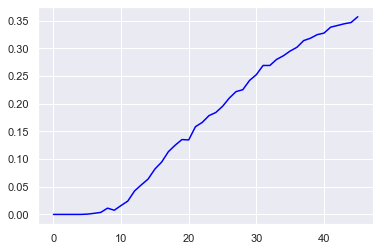

In [7]:
plt.plot(i_beta_32_08, color='blue')

In [8]:
scio.savemat('./i_beta_32_08.mat', {'i_beta_32_08': i_beta_32_08})